In [1]:
import sys
import importlib
import importlib.util

In [2]:
from typing import Any, Union
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")

In [3]:
# Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'neurips':
        width_pt = 397.48499
    elif width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [4]:
def load_train_results(filepath: Union[str, Path]) -> tuple[list, dict[str, Any]]:
    """Loads training results from JSON file."""
    with open(str(filepath), 'r') as f:
        d = json.load(f)
    return d['reward'], d['metrics']

In [5]:
def plot_with_errorbar(ax, data, label, color, plot_method: str = 'mean', error_method: str = 'std', plot_error: bool = True, plot_kwargs: dict = {}, fill_kwargs: dict = {}, **kwargs) -> tuple[np.ndarray, np.ndarray]:
    
    ###
    # Method to highlight the main plot data.
    ###
    y = data
    
    # Plots the average run value at each epoch.
    if plot_method == 'mean':
        y = np.mean(data, axis=0) # (3000,)
        
    elif plot_method == 'mean-rolling':
        df = pd.DataFrame(np.mean(data, axis=0))
        y = df.rolling(10).mean().to_numpy().flatten()
    
    # Plots the run with the maximum average value over the last `n` epochs.
    elif plot_method.startswith('max-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_max = np.argmax(avg_last_n)
        y = data[idx_max] # Plot data is the index of the max.
        
    # Plots the run with the minimum average value over the last `n` epochs.
    elif plot_method.startswith('min-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_min = np.argmin(avg_last_n)
        y = data[idx_min] # Plot data is the index of the min.
    
    else:
        raise ValueError(f"Unsupported plot highlight {plot_method}")
    
    ###
    # Method to produce the shaded error regions.
    ###
    if plot_error:
    
        # Shaded region is +/- standard deviation from the designated `y`-value.
        if error_method.startswith('std') and 'rolling' not in error_method:
            y_std = np.std(data, axis=0)# (3000,)
            n = 1 # Default is 1 std above/below the data.
            if '-' in error_method: # Pull `n` value from method type.
                n = int(error_method.split('-')[-1])
            x = np.arange(data.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
            
        elif error_method == 'std-rolling':
            y_std = pd.DataFrame(y).rolling(10).std().to_numpy().flatten()
            n = 1 # Default is 1 std above/below the data.
            x = np.arange(y.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
        
        # Shaded region is minimum/maximum values at each epoch.
        elif error_method == 'minmax':
            y_min = np.min(data, axis=0) # (3000,)
            y_max = np.max(data, axis=0)# (3000,)
            x = np.arange(data.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
            
        elif error_method == 'minmax-rolling':
            y_min = pd.DataFrame(np.min(data, axis=0)).rolling(10).mean().to_numpy().flatten() # (3000,)
            y_max = pd.DataFrame(np.max(data, axis=0)).rolling(10).mean().to_numpy().flatten() # (3000,)
            x = np.arange(y.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
        
        else:
            raise ValueError(f"Unsupported error method {error_method}")
    
    else:
        x = np.arange(data.shape[-1])
        ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
        # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))

    return x, y

In [6]:
for item in sns.color_palette():
    print(list(item))

[0.2980392156862745, 0.4470588235294118, 0.6901960784313725]
[0.8666666666666667, 0.5176470588235295, 0.3215686274509804]
[0.3333333333333333, 0.6588235294117647, 0.40784313725490196]
[0.7686274509803922, 0.3058823529411765, 0.3215686274509804]
[0.5058823529411764, 0.4470588235294118, 0.7019607843137254]
[0.5764705882352941, 0.47058823529411764, 0.3764705882352941]
[0.8549019607843137, 0.5450980392156862, 0.7647058823529411]
[0.5490196078431373, 0.5490196078431373, 0.5490196078431373]
[0.8, 0.7254901960784313, 0.4549019607843137]
[0.39215686274509803, 0.7098039215686275, 0.803921568627451]


In [7]:
set_size('neurips')

(5.499999861629998, 3.399186852607058)

In [8]:
def generate_figures(figures, series):
    
    # Collect all data from all series and put into frames.
    series_df: dict[str, pd.DataFrame] = {}
    for series_kwargs in series:
        key, blob = series_kwargs['key'], series_kwargs['blob']
        
        files = glob.glob(str(Path(blob).expanduser()))
        session_reward_history = []
        session_metrics_history = []
        for f in files:
            reward_history, metrics_history = load_train_results(str(f))
            session_reward_history.append(reward_history)
            session_metrics_history.append(metrics_history)
            
        # Reshape to proper matrix.
        session_reward_history = session_reward_history
        session_reward_history = np.array(session_reward_history)
        
        df = pd.DataFrame(session_metrics_history)
        series_df[key] = df

    # Generate figures.
    for fig_kwargs in figures:
        
        if fig_kwargs['type'] == 'subplots':
            with sns.axes_style(fig_kwargs.get('seaborn_style', 'ticks'), **fig_kwargs.get('seaborn_style_kwargs', {})), sns.plotting_context(fig_kwargs.get('seaborn_context', 'paper'), **fig_kwargs.get('seaborn_context_kwargs', {})):
                fig, ax = plt.subplots(**fig_kwargs['kwargs'])
            if not isinstance(ax, list):
                ax = [ax]
            ax = np.array(ax).flatten()
            
            
            plot_series_data = {}
            
            for ax_idx, ax_kwargs in enumerate(fig_kwargs['ax']):
                for j, series_kwargs in enumerate(ax_kwargs['series']):
                    
                    series_type = series_kwargs.pop('type', 'plot_with_errorbar')
                    
                    # (default) Metric plot with error region.
                    if series_type == 'plot_with_errorbar':
                        df = series_df[series_kwargs['key']]
                        df_arr = np.array(df.values.tolist())
                        i = list(df.columns).index(ax_kwargs['metric']) # Index of metric key within frame column.
                        x, y = plot_with_errorbar(ax[ax_idx], df_arr[:,i,:], **series_kwargs)
                        plot_series_data[series_kwargs['key']] = (x, y) # Preserve for later.

                    # Horizontal line.
                    elif series_type == 'axhline':
                        ax[ax_idx].axhline(**series_kwargs)

                    # Vertical line.
                    elif series_type == 'axvline':
                        ax[ax_idx].axvline(**series_kwargs)
                        
                    else:
                        raise ValueError(f"Unsupported series type {series_type}")
                    
                    # Restore series type.
                    series_kwargs['type'] = series_type
                
                # Set X ticks.
                if ax_kwargs.get('xticks', None) is not None:
                    ax[ax_idx].set_xticks(**ax_kwargs['xticks'])
                    
                # Set Y ticks.
                if ax_kwargs.get('yticks', None) is not None:
                    ax[ax_idx].set_yticks(**ax_kwargs['yticks'])
                
                # Turn on legend.
                ax[ax_idx].legend(**ax_kwargs['legend_kwargs'])
                
                # Set axis title.
                title = None
                if 'title' in ax_kwargs:
                    title = ax_kwargs['title']
                ax[ax_idx].set_title(title)
                
                # Set axis X-label.
                if 'xlabel' in ax_kwargs:
                    ax[ax_idx].set_xlabel(ax_kwargs['xlabel'])
                
                # Set axis Y-label.
                if 'ylabel' in ax_kwargs:
                    ax[ax_idx].set_ylabel(ax_kwargs['ylabel'])
            
                # Add zoom region to figure.
                if fig_kwargs.get('zoom_region', None) is not None:
                    with sns.axes_style(fig_kwargs.get('seaborn_style', 'ticks'), **fig_kwargs.get('seaborn_style_kwargs', {})), sns.plotting_context(fig_kwargs.get('seaborn_context', 'paper'), **fig_kwargs.get('seaborn_context_kwargs', {})):
                        axins = ax[ax_idx].inset_axes(
                            fig_kwargs['zoom_region']['inset_axes']['bounds'],
                            xlim=fig_kwargs['zoom_region']['inset_axes']['xlim'],
                            ylim=fig_kwargs['zoom_region']['inset_axes']['ylim'],
                        )
                    x1, x2 = fig_kwargs['zoom_region']['inset_axes']['xlim'] # Unpack X-limit to get data at X-index.

                    for series_kwargs in ax_kwargs['series']:

                        series_type = series_kwargs.pop('type')

                        if series_type == 'plot_with_errorbar':
                            key = series_kwargs['key']
                            x, y = plot_series_data[key]
                            axins.plot(x[x1:x2-1], y[x1:x2-1], color=series_kwargs['color'], **series_kwargs['plot_kwargs'])
                        
                        # Horizontal line.
                        elif series_type == 'axhline':
                            axins.axhline(**series_kwargs)

                        # Vertical line.
                        elif series_type == 'axvline':
                            axins.axvline(**series_kwargs)

                        # Restore type.
                        series_kwargs['type'] = series_type
                        
                    ax[ax_idx].indicate_inset_zoom(axins, **fig_kwargs['zoom_region'].get('indicate_inset_zoom', {}))

                # Perform any reporting.
                reports = ax_kwargs.get('reports', [])
                if reports:
                    for report_dict in reports:
                        if report_dict['type'] == 'y-max':
                            for key, (x, y) in plot_series_data.items():
                                idx = np.nanargmax(y)
                                print(f"[report:{report_dict['type']}] {key} max value y={y[idx]} at x={x[idx]} ({idx=})")
                        elif report_dict['type'] == 'y-threshold-max':
                            for key, (x, y) in plot_series_data.items():
                                idx_where = y >= report_dict['yvalue']
                                if not any(idx_where):
                                    print(f"[report:{report_dict['type']}:{report_dict['yvalue']}] {key} NEVER crosses y={report_dict['yvalue']}")
                                else:
                                    idx = np.nanargmax(idx_where)
                                    print(f"[report:{report_dict['type']}:{report_dict['yvalue']}] {key} crosses y={report_dict['yvalue']} at x={x[idx]} ({idx=})")
                        else:
                            raise ValueError(f"Unsupported report type {report_dict['type']}")
            
            # sns.despine(fig)

            # Save figure to file.
            if 'savefig_kwargs' in fig_kwargs:
                fig.savefig(**fig_kwargs['savefig_kwargs'])
                print(f"Saved figure: {fig_kwargs['savefig_kwargs']['fname']}")
                
            print(flush=True)

    plt.show()

Figure config loaded: fig_maa2c_mdp from ../figures/fig_maa2c_mdp.py
[report:y-threshold-max:20] $\mathtt{fCTDE}$ crosses y=20 at x=1917 (idx=1917)
[report:y-threshold-max:20] $\mathtt{qfCTDE}$ crosses y=20 at x=678 (idx=678)
[report:y-threshold-max:20] $\mathtt{sCTDE}$ crosses y=20 at x=1640 (idx=1640)
[report:y-threshold-max:20] $\mathtt{eQMARL-}\Psi^{+}$ crosses y=20 at x=568 (idx=568)
[report:y-threshold-max:25] $\mathtt{fCTDE}$ NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{qfCTDE}$ NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{sCTDE}$ crosses y=25 at x=2615 (idx=2615)
[report:y-threshold-max:25] $\mathtt{eQMARL-}\Psi^{+}$ crosses y=25 at x=2332 (idx=2332)
[report:y-max] $\mathtt{fCTDE}$ max value y=23.67 at x=2925 (idx=2925)
[report:y-max] $\mathtt{qfCTDE}$ max value y=23.38 at x=2378 (idx=2378)
[report:y-max] $\mathtt{sCTDE}$ max value y=25.3 at x=2631 (idx=2631)
[report:y-max] $\mathtt{eQMARL-}\Psi^{+}$ max value y=25.669999999999998 at x=2942 (idx=2942)
Save

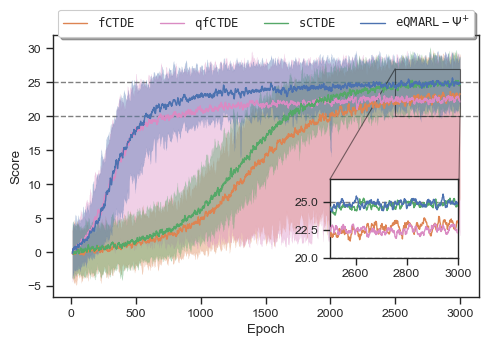

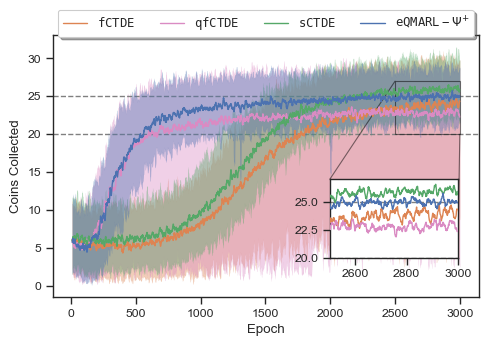

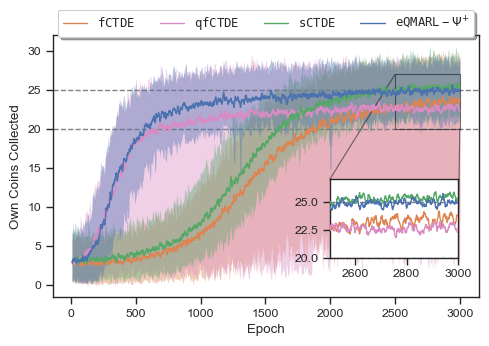

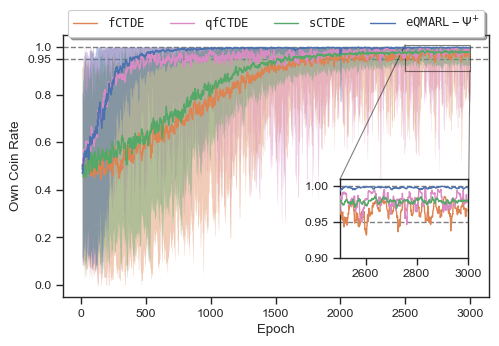


Figure config loaded: fig_maa2c_pomdp from ../figures/fig_maa2c_pomdp.py
[report:y-threshold-max:20] $\mathtt{fCTDE}$ crosses y=20 at x=1798 (idx=1798)
[report:y-threshold-max:20] $\mathtt{qfCTDE}$ crosses y=20 at x=1382 (idx=1382)
[report:y-threshold-max:20] $\mathtt{sCTDE}$ crosses y=20 at x=1738 (idx=1738)
[report:y-threshold-max:20] $\mathtt{eQMARL-}\Psi^{+}$ crosses y=20 at x=1049 (idx=1049)
[report:y-threshold-max:25] $\mathtt{fCTDE}$ crosses y=25 at x=2658 (idx=2658)
[report:y-threshold-max:25] $\mathtt{qfCTDE}$ crosses y=25 at x=2124 (idx=2124)
[report:y-threshold-max:25] $\mathtt{sCTDE}$ crosses y=25 at x=2750 (idx=2750)
[report:y-threshold-max:25] $\mathtt{eQMARL-}\Psi^{+}$ crosses y=25 at x=1745 (idx=1745)
[report:y-max] $\mathtt{fCTDE}$ max value y=25.490000000000002 at x=2824 (idx=2824)
[report:y-max] $\mathtt{qfCTDE}$ max value y=26.089999999999996 at x=2871 (idx=2871)
[report:y-max] $\mathtt{sCTDE}$ max value y=25.33 at x=2999 (idx=2999)
[report:y-max] $\mathtt{eQMARL-}

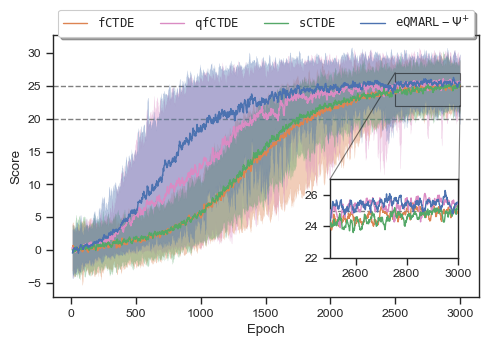

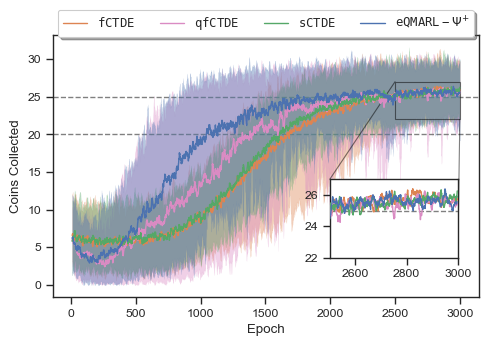

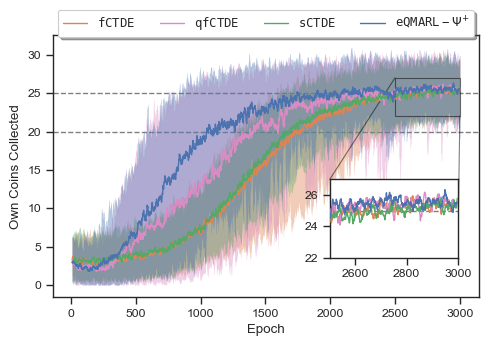

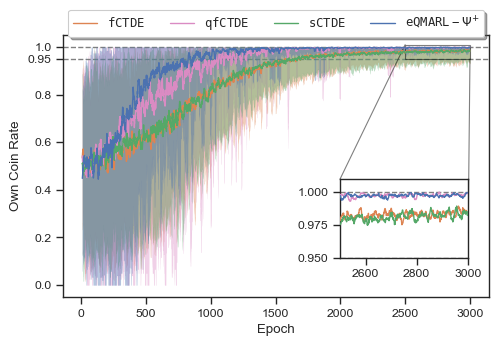


Figure config loaded: fig_maa2c_mdp_entanglement_compare from ../figures/fig_maa2c_mdp_entanglement_compare.py
[report:y-threshold-max:20] $\Psi^{+}$ crosses y=20 at x=568 (idx=568)
[report:y-threshold-max:20] $\Psi^{-}$ crosses y=20 at x=595 (idx=595)
[report:y-threshold-max:20] $\Phi^{+}$ crosses y=20 at x=612 (idx=612)
[report:y-threshold-max:20] $\Phi^{-}$ crosses y=20 at x=691 (idx=691)
[report:y-threshold-max:20] $\mathtt{None}$ crosses y=20 at x=839 (idx=839)
[report:y-threshold-max:25] $\Psi^{+}$ crosses y=25 at x=2332 (idx=2332)
[report:y-threshold-max:25] $\Psi^{-}$ crosses y=25 at x=1987 (idx=1987)
[report:y-threshold-max:25] $\Phi^{+}$ crosses y=25 at x=1883 (idx=1883)
[report:y-threshold-max:25] $\Phi^{-}$ crosses y=25 at x=2378 (idx=2378)
[report:y-threshold-max:25] $\mathtt{None}$ crosses y=25 at x=2337 (idx=2337)
[report:y-max] $\Psi^{+}$ max value y=25.669999999999998 at x=2942 (idx=2942)
[report:y-max] $\Psi^{-}$ max value y=25.45 at x=2849 (idx=2849)
[report:y-max] 

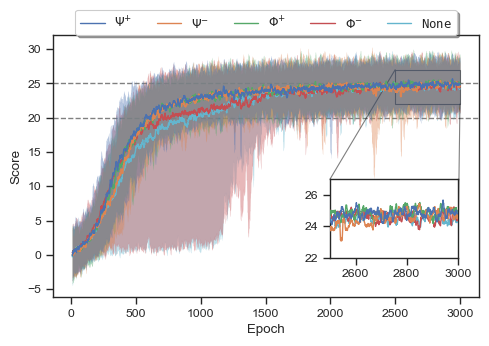

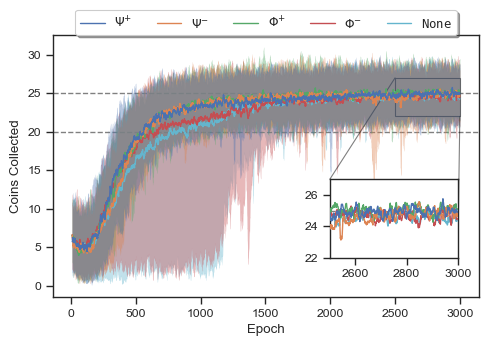

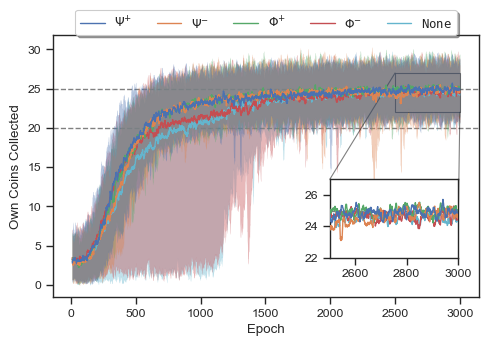

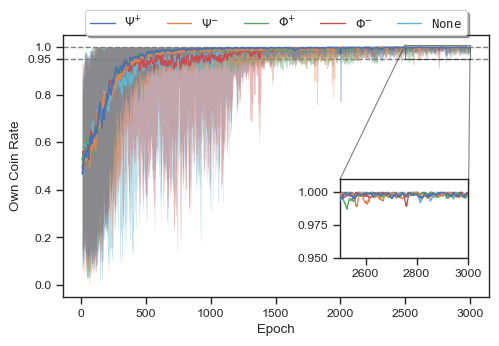


Figure config loaded: fig_maa2c_pomdp_entanglement_compare from ../figures/fig_maa2c_pomdp_entanglement_compare.py
[report:y-threshold-max:20] $\Psi^{+}$ crosses y=20 at x=1049 (idx=1049)
[report:y-threshold-max:20] $\Psi^{-}$ crosses y=20 at x=1206 (idx=1206)
[report:y-threshold-max:20] $\Phi^{+}$ crosses y=20 at x=1269 (idx=1269)
[report:y-threshold-max:20] $\Phi^{-}$ crosses y=20 at x=1838 (idx=1838)
[report:y-threshold-max:20] $\mathtt{None}$ crosses y=20 at x=1069 (idx=1069)
[report:y-threshold-max:25] $\Psi^{+}$ crosses y=25 at x=1745 (idx=1745)
[report:y-threshold-max:25] $\Psi^{-}$ crosses y=25 at x=2114 (idx=2114)
[report:y-threshold-max:25] $\Phi^{+}$ NEVER crosses y=25
[report:y-threshold-max:25] $\Phi^{-}$ NEVER crosses y=25
[report:y-threshold-max:25] $\mathtt{None}$ crosses y=25 at x=1955 (idx=1955)
[report:y-max] $\Psi^{+}$ max value y=26.28 at x=2950 (idx=2950)
[report:y-max] $\Psi^{-}$ max value y=25.95 at x=2999 (idx=2999)
[report:y-max] $\Phi^{+}$ max value y=24.1 a

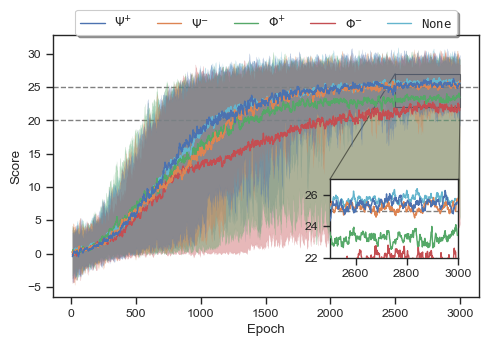

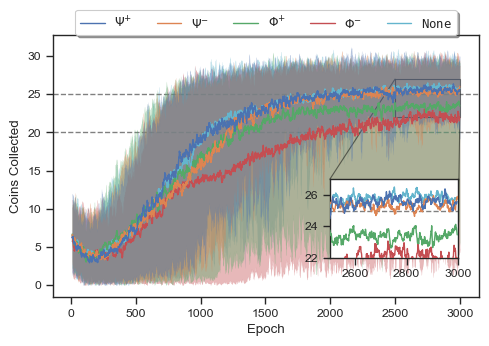

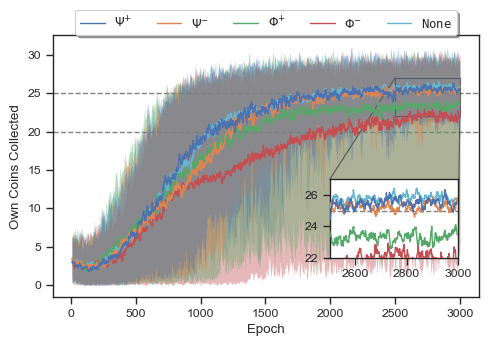

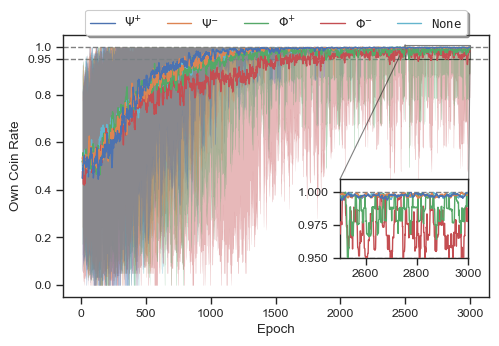

In [14]:
configs = [
    '../figures/fig_maa2c_mdp.py',
    '../figures/fig_maa2c_pomdp.py',
    '../figures/fig_maa2c_mdp_entanglement_compare.py',
    '../figures/fig_maa2c_pomdp_entanglement_compare.py',
]
for path in configs:
    path = Path(path)
    mod_name = f"{path.stem}"
    
    if mod_name in sys.modules:
        del sys.modules[mod_name]
    spec = importlib.util.spec_from_file_location(mod_name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    
    print(f"Figure config loaded: {mod_name} from {path}")
    
    generate_figures(mod.figures, mod.series)
    print(flush=True)